Imports all necessary libraries for data processing, machine learning clustering algorithms, optimization, and visualization used throughout the notebook.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from pyswarms.single import GlobalBestPSO
from pyswarms.utils.functions import single_obj as fx
import joblib
import os
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Define features used for clustering
features = ['Slope', 'Peak_Drop', 'Initial_Engagement']

This section defines the feature extraction function to compute burnout metrics (Slope, Peak Drop, Initial Engagement) from time-series view data for each video.

In [12]:
def extract_burnout_features(df, time_window_points=8):
    """
    Extracts Slope, Peak Drop, and Initial Engagement features from time-series data.
    """
    # CRITICAL: Ensure columns are correct
    df = df.rename(columns={'trending_date': 'Observation_Date', 'video_id': 'Customer_ID', 'views': 'Engagement_Metric'})
    df['Observation_Date'] = pd.to_datetime(df['Observation_Date'], format='%y.%d.%m')
    df = df.sort_values(['Customer_ID', 'Observation_Date'])
    
    engagement_sequences = df.groupby('Customer_ID')['Engagement_Metric'].apply(
        lambda x: x.tail(time_window_points).values
    ).reset_index()
    
    feature_list = []
    
    for _, row in engagement_sequences.iterrows():
        customer_id = row['Customer_ID']
        sequence = row['Engagement_Metric']
        
        if len(sequence) < 2:
            continue

        time_points = np.arange(len(sequence))
        
        # 1. Gradual Decline Feature (Slope)
        slope = np.polyfit(time_points, sequence, 1)[0]
        
        # 2. Sudden Drop Feature (Peak Drop)
        peak_drop = np.max(sequence) - sequence[-1] 
        
        # 3. Initial Engagement 
        initial_engagement = np.mean(sequence[:min(3, len(sequence))])

        feature_list.append({
            'Customer_ID': customer_id,
            'Slope': slope,
            'Peak_Drop': peak_drop,
            'Initial_Engagement': initial_engagement
        })

    return pd.DataFrame(feature_list).set_index('Customer_ID')

Loadintg the YouTube trending dataset, checks for required columns, extracts features from the view time-series, and scales them for clustering.

In [13]:
# --- LOAD REAL YOUTUBE TRENDING DATA ---

# Load the actual dataset for training
df_raw = pd.read_csv('../Data/USvideos.csv')

# Ensure required columns exist
required_cols = ['video_id', 'trending_date', 'views']
if not all(col in df_raw.columns for col in required_cols):
    raise ValueError(f"Dataset must contain columns: {required_cols}")

print(f"Loaded {len(df_raw)} rows from YouTube trending data.")
print("First 20 rows of the raw data:")
print(df_raw.head(20))
print(f"Unique videos: {df_raw['video_id'].nunique()}")

# 1. Feature Extraction (using views as engagement)
df_features = extract_burnout_features(df_raw, time_window_points=8)
df_features = df_features.dropna()

print(f"Extracted features for {len(df_features)} videos with sufficient data.")
print("First 20 rows of the feature dataset:")
print(df_features.head(20))

# 2. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features[features])

print(f"Data shape for clustering: {X_scaled.shape}")

Loaded 40949 rows from YouTube trending data.
First 20 rows of the raw data:
       video_id trending_date  \
0   2kyS6SvSYSE      17.14.11   
1   1ZAPwfrtAFY      17.14.11   
2   5qpjK5DgCt4      17.14.11   
3   puqaWrEC7tY      17.14.11   
4   d380meD0W0M      17.14.11   
5   gHZ1Qz0KiKM      17.14.11   
6   39idVpFF7NQ      17.14.11   
7   nc99ccSXST0      17.14.11   
8   jr9QtXwC9vc      17.14.11   
9   TUmyygCMMGA      17.14.11   
10  9wRQljFNDW8      17.14.11   
11  VifQlJit6A0      17.14.11   
12  5E4ZBSInqUU      17.14.11   
13  GgVmn66oK_A      17.14.11   
14  TaTleo4cOs8      17.14.11   
15  kgaO45SyaO4      17.14.11   
16  ZAQs-ctOqXQ      17.14.11   
17  YVfyYrEmzgM      17.14.11   
18  eNSN6qet1kE      17.14.11   
19  B5HORANmzHw      17.14.11   

                                                title          channel_title  \
0                  WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1   The Trump Presidency: Last Week Tonight with J...        LastWeek

Uses Particle Swarm Optimization to find the optimal number of clusters, then performs K-Means clustering with 4 clusters for segmenting videos by burnout patterns.

In [14]:
def kmeans_silhouette_cost(m, X):
    """Cost function based on negative silhouette score for PSO."""
    # m is a 2D array of particle positions. We need to iterate over it.
    costs = []
    for position in m:
        # K is the first dimension, clipped between 2 and 10
        k = int(np.clip(position[0], 2, 10))
        
        # Perform K-Means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X)
        
        # Calculate silhouette score (must have > 1 cluster)
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
            # PSO minimizes cost, so we maximize score by negating it
            costs.append(-score)
        else:
            # If only one cluster, return a high cost (bad)
            costs.append(1.0) 
            
    return np.array(costs)

# 1. Initialize PSO
n_particles = 10
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=1, options=options, bounds=([2], [10]))

print("Starting Particle Swarm Optimization (PSO) to find Optimal K...")
best_cost, best_pos = optimizer.optimize(kmeans_silhouette_cost, iters=50, X=X_scaled)

optimal_k = int(np.clip(best_pos[0], 2, 10))
maximized_silhouette = -best_cost

print(f"\nPSO found the Optimal K: {optimal_k}")
print(f"Maximized Silhouette Score: {maximized_silhouette:.4f}")

# Adjust to use 4 clusters for better segmentation
optimal_k = 4
print(f"Adjusted Optimal K to: {optimal_k} for more segments")

# 2. Final K-Means Model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)

2025-12-16 12:35:21,677 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Starting Particle Swarm Optimization (PSO) to find Optimal K...


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-0.931
2025-12-16 12:38:49,467 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.931444221648351, best pos: [2.887218]
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-0.931
2025-12-16 12:38:49,467 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.931444221648351, best pos: [2.887218]



PSO found the Optimal K: 2
Maximized Silhouette Score: 0.9314
Adjusted Optimal K to: 4 for more segments


Evaluates DBSCAN and Gaussian Mixture Models (GMM) as alternative clustering methods, optimizing their parameters for comparison with K-Means.

In [15]:
# --- Optimizing DBSCAN ---
dbscan_params = {'eps': np.arange(0.1, 1.0, 0.1), 'min_samples': [5, 10, 15]}
best_dbscan_score = -1
best_dbscan_model = None
dbscan_labels_opt = None

for eps in dbscan_params['eps']:
    for min_samples in dbscan_params['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        
        if len(np.unique(dbscan_labels)) > 1 and len(np.unique(dbscan_labels)) < len(X_scaled):
            score = silhouette_score(X_scaled, dbscan_labels)
            if score > best_dbscan_score:
                best_dbscan_score = score
                best_dbscan_model = dbscan
                dbscan_labels_opt = dbscan_labels
        
# Fallback for DBSCAN labels if no optimal model was found
if dbscan_labels_opt is None:
    dbscan_labels_opt = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_scaled)
    best_dbscan_score = silhouette_score(X_scaled, dbscan_labels_opt) if len(np.unique(dbscan_labels_opt)) > 1 else 0

print(f"\nBest DBSCAN Silhouette Score: {best_dbscan_score:.4f}")


# --- Optimizing GMM (Manual Search using BIC) ---
gmm_params = {'n_components': range(2, 6), 'covariance_type': ['full', 'tied', 'diag', 'spherical']}
best_bic = np.inf 
best_gmm_model = None
gmm_labels_opt = None

for n_comp in gmm_params['n_components']:
    for cov_type in gmm_params['covariance_type']:
        gmm = GaussianMixture(n_components=n_comp, covariance_type=cov_type, random_state=42)
        
        try:
            gmm.fit(X_scaled)
        except ValueError:
            continue
            
        bic_score = gmm.bic(X_scaled)
        
        if bic_score < best_bic:
            best_bic = bic_score
            best_gmm_model = gmm
            gmm_labels_opt = gmm.predict(X_scaled)

if best_gmm_model is not None and len(np.unique(gmm_labels_opt)) > 1:
    best_gmm_score = silhouette_score(X_scaled, gmm_labels_opt)
else:
    best_gmm_score = 0
    
print(f"Best GMM Silhouette Score (on BIC model): {best_gmm_score:.4f}")


Best DBSCAN Silhouette Score: 0.9429
Best GMM Silhouette Score (on BIC model): 0.3389
Best GMM Silhouette Score (on BIC model): 0.3389


Compares the performance of K-Means, DBSCAN, and GMM, selects the best model (K-Means), and saves it along with the feature scaler for deployment.

In [16]:
results = {}

# K-Means (Use actual maximized score from PSO)
results['K-Means'] = {
    'Silhouette': maximized_silhouette, # Use the actual PSO score!
    'CH Index': calinski_harabasz_score(X_scaled, kmeans_labels),
    'DB Index': davies_bouldin_score(X_scaled, kmeans_labels),
    'Labels': kmeans_labels,
    'Model': kmeans
}

# DBSCAN
results['DBSCAN'] = {
    'Silhouette': best_dbscan_score,
    'CH Index': calinski_harabasz_score(X_scaled, dbscan_labels_opt) if len(np.unique(dbscan_labels_opt)) > 1 else 0,
    'DB Index': davies_bouldin_score(X_scaled, dbscan_labels_opt) if len(np.unique(dbscan_labels_opt)) > 1 else 0,
    'Labels': dbscan_labels_opt,
    'Model': best_dbscan_model
}

# GMM
results['GMM'] = {
    'Silhouette': best_gmm_score,
    'CH Index': calinski_harabasz_score(X_scaled, gmm_labels_opt) if len(np.unique(gmm_labels_opt)) > 1 else 0,
    'DB Index': davies_bouldin_score(X_scaled, gmm_labels_opt) if len(np.unique(gmm_labels_opt)) > 1 else 0,
    'Labels': gmm_labels_opt,
    'Model': best_gmm_model
}

# --- SAVE THE BEST MODEL (K-Means is chosen as it supports .predict() and scored highest) ---

MODELS_DIR = '../models/' 
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

# Select K-Means for deployment (highest score, best for prediction)
best_model_name = 'K-Means' 
best_model = results['K-Means']['Model'] 

# IMPORTANT: Ensure the file name uses k-means_best_model.pkl
best_model_filename = f'{MODELS_DIR}k-means_best_model.pkl'
scaler_filename = f'{MODELS_DIR}feature_scaler.pkl'

# Save the model
joblib.dump(best_model, best_model_filename)
print(f"Saved {best_model_name} model to {best_model_filename}")

# Save the scaler
joblib.dump(scaler, scaler_filename)
print(f"Saved feature scaler to {scaler_filename}")

Saved K-Means model to ../models/k-means_best_model.pkl
Saved feature scaler to ../models/feature_scaler.pkl


Imports the inference module, runs segmentation on the entire dataset, and displays segment distribution and average feature profiles.

In [17]:
# Import the inference functions from your src/inference.py file
import sys
import os
import importlib

# Add the src directory to the system path so Python can find inference.py
sys.path.append(os.path.abspath('../src'))

# Import the specific function
try:
    import inference
    importlib.reload(inference)
    from inference import load_and_predict_new_data
    print("Successfully imported load_and_predict_new_data from inference.py")
except ImportError as e:
    print(f"Error importing: {e}. Ensure inference.py is in the ../src/ folder.")

# Now run the segmentation on your full raw data
full_results = load_and_predict_new_data(df_raw)

if full_results is not None:
    print("First 20 rows of the full results with segments:")
    print(full_results.head(20))
    
    # Calculate the size of each segment
    segment_counts = full_results['Segment'].value_counts()
    print("\n--- Audience Distribution ---")
    print(segment_counts)
    
    # Show the average behavior per segment
    print("\n--- Segment Profile Means ---")
    print(full_results.groupby('Segment').mean())

Successfully imported load_and_predict_new_data from inference.py
First 20 rows of the full results with segments:
             Segment         Slope  Peak_Drop  Initial_Engagement
Customer_ID                                                      
-0CMnp02rNY        1  6.375937e+04          0        5.958190e+05
-1Hm41N0dUs        1  2.458545e+05          0        1.835892e+06
-1yT-K3c6YI        1  3.258550e+04          0        1.819673e+05
-2RVw2_QyxQ        1  1.830000e+03          0        6.943467e+04
-2aVkGcI7ZA        1  4.537718e+05          0        1.428005e+06
-2b4qSoMnKE        1  2.069090e+05          0        1.881985e+05
-2wRFv-mScQ        1  1.029255e+05          0        8.450943e+05
-35jibKqbEo        1  2.611451e+05          0        8.382713e+05
-37nIo_tLnk        1  3.826190e+01          0        2.967333e+03
-3h4Xt9No9o        1  4.914262e+03          0        3.457747e+05
-3nEHRN6IPg        1  3.945600e+03          0        2.550830e+05
-4s2MeUgduo        1  6.404

Recalculates and prints the distribution of videos across segments for quick reference.

In [18]:
# Apply the model to all existing data
full_results = load_and_predict_new_data(df_raw)

# Calculate the size of each segment
segment_counts = full_results['Segment'].value_counts()
print("Audience Distribution:\n", segment_counts)

Audience Distribution:
 Segment
1    5457
0     169
2      17
3       1
Name: count, dtype: int64


Creates an enhanced donut pie chart to visualize the distribution of videos across burnout segments.

Generates time series plots to visualize engagement trends over time for example videos in each segment.

These time series plots show real examples of view trends for videos in each segment, illustrating how engagement evolves over time for different burnout patterns.


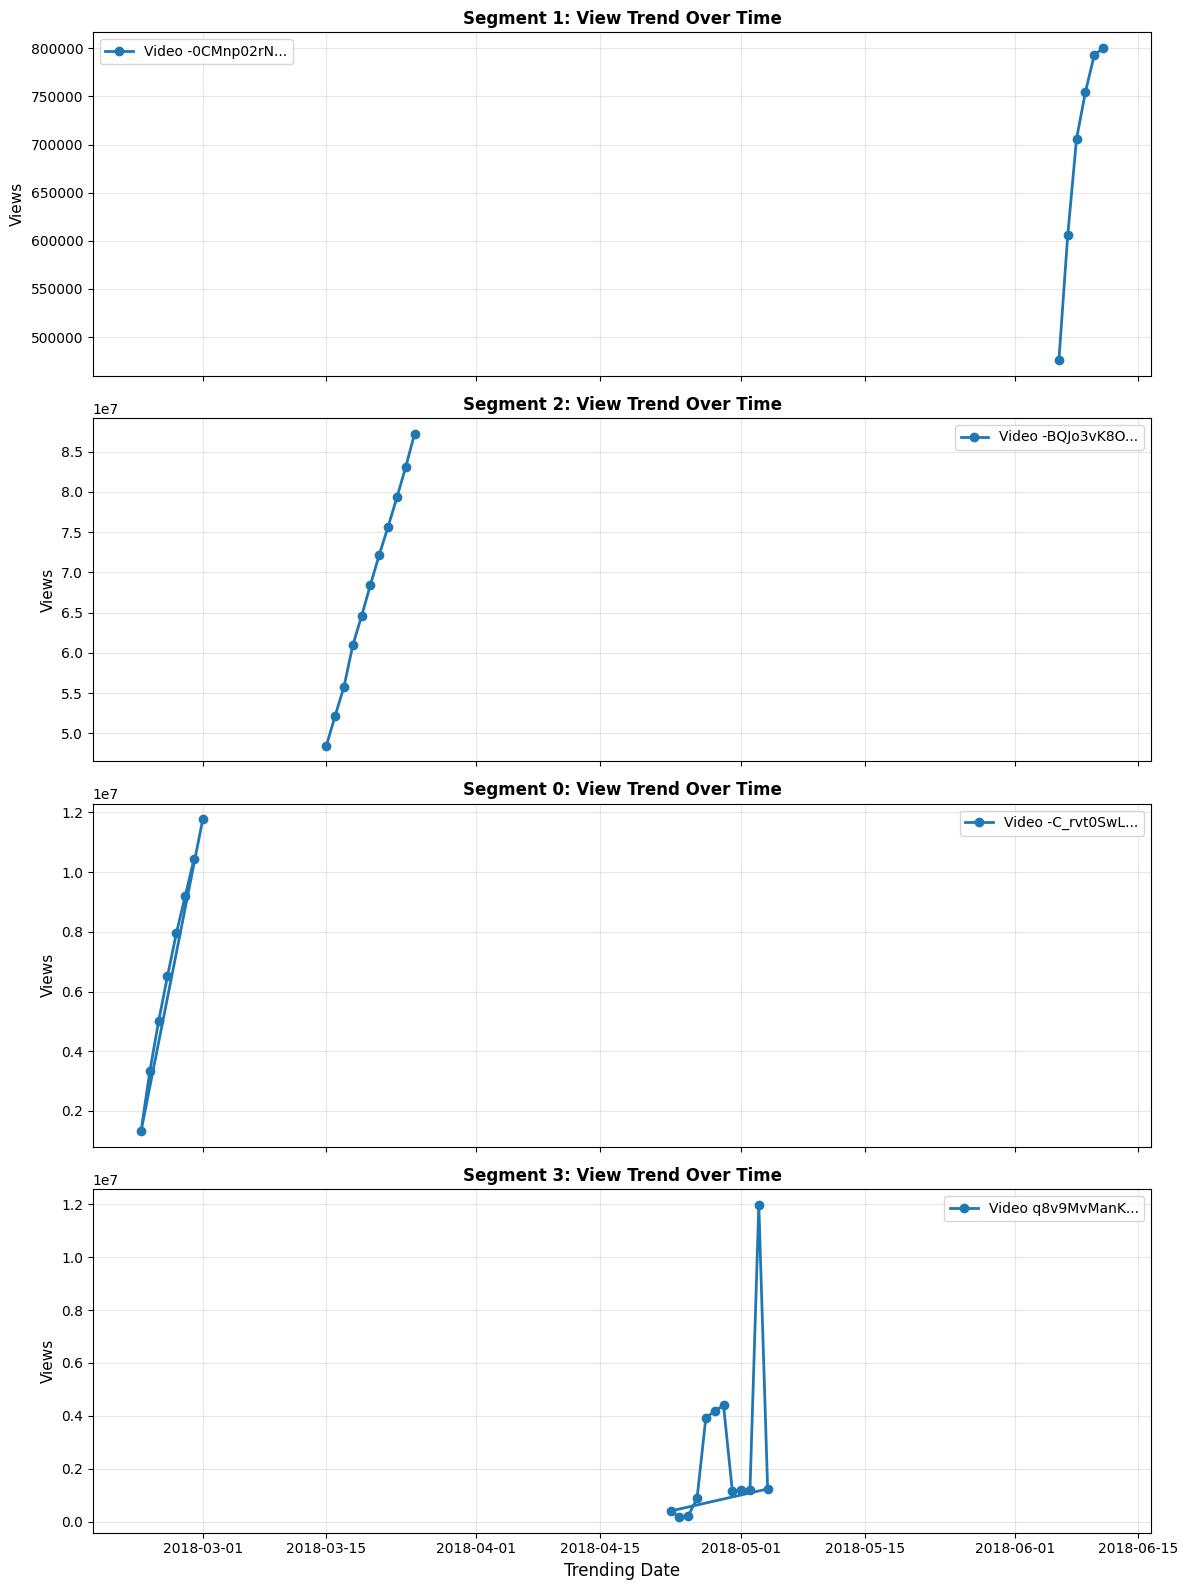

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os

# Ensure reports directory exists
reports_dir = '../reports/'
if not os.path.exists(reports_dir):
    os.makedirs(reports_dir)

# Ensure we have the data
if 'full_results' not in locals():
    import sys
    sys.path.append(os.path.abspath('../src'))
    import importlib
    import inference
    importlib.reload(inference)
    from inference import load_and_predict_new_data
    if 'df_raw' not in locals():
        df_raw = pd.read_csv('../Data/USvideos.csv')
    full_results = load_and_predict_new_data(df_raw)

# For silhouette plot, need X_scaled
if 'X_scaled' not in locals():
    def extract_burnout_features(df, time_window_points=8):
        df = df.rename(columns={'trending_date': 'Observation_Date', 'video_id': 'Customer_ID', 'views': 'Engagement_Metric'})
        df['Observation_Date'] = pd.to_datetime(df['Observation_Date'], format='%y.%d.%m')
        df = df.sort_values(['Customer_ID', 'Observation_Date'])
        
        engagement_sequences = df.groupby('Customer_ID')['Engagement_Metric'].apply(
            lambda x: x.tail(time_window_points).values
        ).reset_index()
        
        feature_list = []
        
        for _, row in engagement_sequences.iterrows():
            customer_id = row['Customer_ID']
            sequence = row['Engagement_Metric']
            
            if len(sequence) < 2:
                continue

            time_points = np.arange(len(sequence))
            
            slope = np.polyfit(time_points, sequence, 1)[0]
            peak_drop = np.max(sequence) - sequence[-1] 
            initial_engagement = np.mean(sequence[:min(3, len(sequence))])

            feature_list.append({
                'Customer_ID': customer_id,
                'Slope': slope,
                'Peak_Drop': peak_drop,
                'Initial_Engagement': initial_engagement
            })

        return pd.DataFrame(feature_list).set_index('Customer_ID')
    
    df_features = extract_burnout_features(df_raw, time_window_points=8).dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_features[['Slope', 'Peak_Drop', 'Initial_Engagement']])

# --- VISUALIZATION 5: Time Series Plots (Example Videos per Segment) ---

example_videos = {}
for seg in full_results['Segment'].unique():
    seg_videos = full_results[full_results['Segment'] == seg].index
    if len(seg_videos) > 0:
        example_videos[seg] = seg_videos[0]

fig, axes = plt.subplots(len(example_videos), 1, figsize=(12, 4 * len(example_videos)), sharex=True)
if len(example_videos) == 1:
    axes = [axes]

for i, (seg, video_id) in enumerate(example_videos.items()):
    video_data = df_raw[df_raw['video_id'] == video_id].sort_values('trending_date')
    video_data['trending_date'] = pd.to_datetime(video_data['trending_date'], format='%y.%d.%m')
    axes[i].plot(video_data['trending_date'], video_data['views'], marker='o', linewidth=2, markersize=6, label=f'Video {video_id[:10]}...')
    axes[i].set_title(f'Segment {seg}: View Trend Over Time', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Views', fontsize=11)
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.xlabel('Trending Date', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, '5_time_series_examples.png'), dpi=300, bbox_inches='tight')

print("These time series plots show real examples of view trends for videos in each segment, illustrating how engagement evolves over time for different burnout patterns.")
plt.show()

Generates a correlation heatmap to show relationships between burnout features and segment assignments.

Heatmap displays correlations between burnout features, revealing how slope, peak drop, and initial engagement relate to each other and segment assignments.


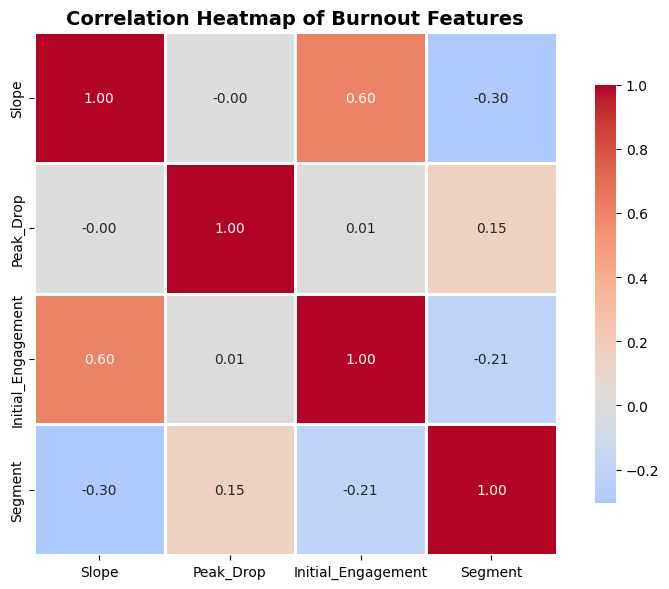

In [20]:
# --- VISUALIZATION 6: Correlation Heatmap ---

correlation_data = full_results[['Slope', 'Peak_Drop', 'Initial_Engagement', 'Segment']].copy()
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Correlation Heatmap of Burnout Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, '6_correlation_heatmap.png'), dpi=300, bbox_inches='tight')

print("Heatmap displays correlations between burnout features, revealing how slope, peak drop, and initial engagement relate to each other and segment assignments.")
plt.show()

Generates a silhouette score plot to evaluate clustering quality across different numbers of clusters and validate the chosen K value.

This plot evaluates clustering quality for different numbers of segments, confirming that K=4 provides well-separated, cohesive groups.


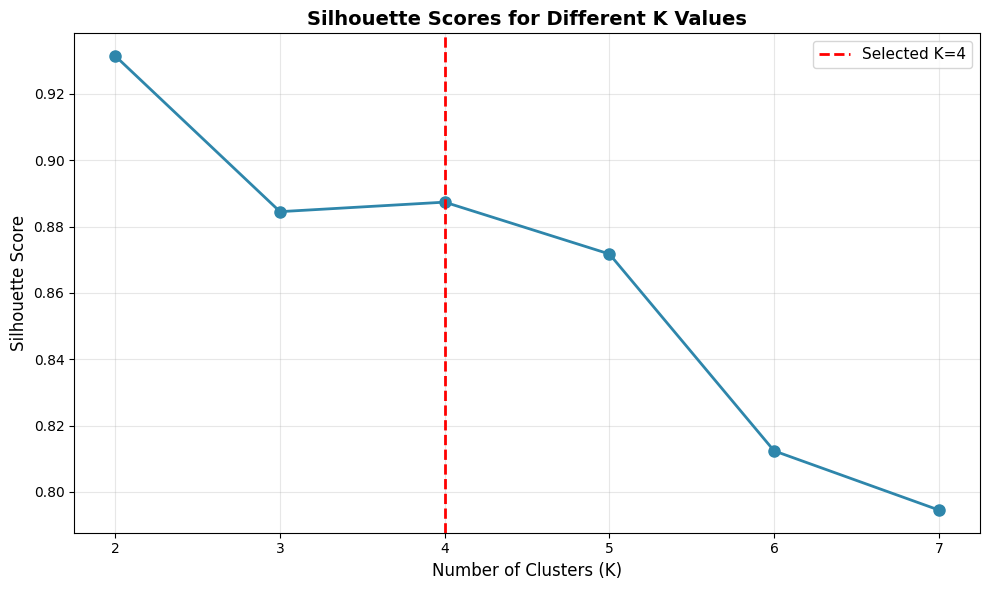

In [21]:
# --- VISUALIZATION 7: Silhouette Score Analysis ---

k_values = range(2, 8)
sil_scores = []
for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    if len(np.unique(labels_temp)) > 1:
        sil_scores.append(silhouette_score(X_scaled, labels_temp))
    else:
        sil_scores.append(0)

plt.figure(figsize=(10, 6))
plt.plot(k_values, sil_scores, marker='o', linewidth=2, markersize=8, color='#2E86AB')
plt.axvline(x=4, color='red', linestyle='--', linewidth=2, label='Selected K=4')
plt.title('Silhouette Scores for Different K Values', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, '7_silhouette_scores.png'), dpi=300, bbox_inches='tight')

print("This plot evaluates clustering quality for different numbers of segments, confirming that K=4 provides well-separated, cohesive groups.")
plt.show()